In [1]:
import pandas as pd
import numpy as np
import random, operator
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt, pi

In [2]:
# Data used below are the real coordinates of 8 major airports in Asia
# The values in the dictionary below represent the latitude and longitude of the major airports

airport_dict = {'Beijing':[40.0799, 116.6031], 'Dubai':[25.2532, 55.3657], 'Tokyo':[35.5494, 139.7798], 'Hong Kong':[22.3080, 113.9185], 'Shanghai':[31.1443, 121.8083], 'Delhi':[28.5562, 77.1000], 'Guangzhou':[23.3959, 113.3080], 'Seoul':[37.4602, 126.4407]}

airport_names = list(airport_dict.keys())
airport_cord = list(airport_dict.values()) 
print(airport_names)
print(airport_cord)

['Beijing', 'Dubai', 'Tokyo', 'Hong Kong', 'Shanghai', 'Delhi', 'Guangzhou', 'Seoul']
[[40.0799, 116.6031], [25.2532, 55.3657], [35.5494, 139.7798], [22.308, 113.9185], [31.1443, 121.8083], [28.5562, 77.1], [23.3959, 113.308], [37.4602, 126.4407]]


In [3]:
# Calculates the distance between two airports(Cities)
def calculateDistance(airports):
    total = dict()
    for idx, value in enumerate(airports):
        lat1 = airports[idx][0]
        lon1 = airports[idx][1]
        if idx + 1 <= len(airports) - 1:
            lat2 = airports[idx+1][0]
            lon2 = airports[idx+1][1]
            
            # Using 'Haversine Formula' to calculate the distance
            dlat = (lat2 - lat1) * pi / 180.0
            dlon = (lon2 - lon1) * pi / 180.0
            
            lat1 = (lat1) * pi / 180.0
            lat2 = (lat2) * pi / 180.0
            
            a = (pow(sin(dlat / 2), 2) + pow(sin(dlon / 2), 2) * cos(lat1) * cos(lat2))
            rad = 6371
            distance = 2 * asin(sqrt(a)) * rad
            total['From city ' + str(idx+1) + ' to city ' + str(idx+2)] = distance
            
        else:
            lat2 = airports[0][0]
            lon2 = airports[0][1]
            
            dlat = (lat2 - lat1) * pi / 180.0
            dlon = (lon2 - lon1) * pi / 180.0
            
            lat1 = (lat1) * pi / 180.0
            lat2 = (lat2) * pi / 180.0
            
            a = (pow(sin(dlat / 2), 2) + pow(sin(dlon / 2), 2) * cos(lat1) * cos(lat2))
            rad = 6371
            distance = 2 * asin(sqrt(a)) * rad
            total['From city ' + str(idx+1) + ' to city ' + str(idx+2-len(airports))] = distance
    return total                                                                 

In [4]:
# Calculates the total distance of the route
def totalDistance(airports):
    total = sum(calculateDistance(airports).values())
    return total
totalDistance(airport_cord)

28786.060117879777

# 1. Initial Population

In [5]:
# Create random route to visit each airport(city)
def flightRoute(airports):
    route = random.sample(airports, len(airports))
    return route


In [6]:
# Create initial population(list of routes)
def initialPopulation(airports, populationSize):
    population = [flightRoute(airports) for i in range(0, populationSize)]
    return population


# 2. Fitness Function

In [7]:
# Calculate the fitness of the route
def routeFitness(airports):
    totalDist = totalDistance(airports)
    fitness= 0.0
    if fitness == 0:
        fitness = 1 / float(totalDist)
    return fitness


In [8]:
# Rank the routes
def rankRoutes(population):
    fitnessResults = {}
    for i in range(len(population)):
        fitnessResults[i] = routeFitness(population[i])
        
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)


# 3. Selection

In [9]:
# Selection of the best performing routes
def selection(popRanked, eliteSize):
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cumulative_sum'] = df.Fitness.cumsum()
    df['cum_percentage'] = 100*df.cumulative_sum/df.Fitness.sum()
    
    selectedRoutes = [popRanked[i][0] for i in range(eliteSize)]
    for i in range(len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectedRoutes.append(popRanked[i][0])
                break
                
    return selectedRoutes

In [10]:
# Create Mating Pool
def matingPool(population, selectedRoutes):
    matingpool = [population[selectedRoutes[i]] for i in range(len(selectedRoutes))]
    return matingpool


# 4. Crossover

In [11]:
# Ordered crossover or breeding to create one child
def breed(parent1, parent2):
    gene_x = int(random.random() * len(parent1))
    gene_y = int(random.random() * len(parent1))
    start_position = min(gene_x, gene_y)
    end_position = max(gene_x, gene_y)

    geneOfParent1 = [parent1[i] for i in range(start_position, end_position)]
    geneOfParent2 = [i for i in parent2 if i not in geneOfParent1]

    child = geneOfParent1 + geneOfParent2
    return child

In [12]:
# Crossover or breeding over the mating pool
def breedPopulation(matingpool, eliteSize):
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))
    children1 = [matingpool[i] for i in range(eliteSize)]
    children2 = [breed(pool[i], pool[len(matingpool)-i-1]) for i in range(length)]
    children = children1 + children2
    return children


# 5. Mutation

In [13]:
# Swap mutation for single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swappedWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swappedWith]
            
            individual[swapped] = city2
            individual[swappedWith] = city1
    return individual

In [14]:
# Mutation over entire population
def mutatePopulation(population, mutationRate):
    mutatedpopulation = [mutate(population[i], mutationRate) for i in range(len(population))]
    return mutatedpopulation


# Next Generation

In [15]:
# Create next generation
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectedRoutes = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectedRoutes)
    children = breedPopulation(matingpool, eliteSize)
    nxtgeneration = mutatePopulation(children, mutationRate)
    return nxtgeneration


In [16]:
# Get names of airports(cities) with respective routes
def getAirports(bestRoute, airports, airport_names):
    names = []
    for idx,val in enumerate(bestRoute):
        for i,v in enumerate(airports):
            if val == v:
                names.append(airport_names[i])
    return names

# Genetic Algorithm

In [17]:
# Create Genetic Algorithm
def geneticAlgorithm(airport_names, airports, populationSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(airports,populationSize)
    print("Initial Distance: " + str(1 / rankRoutes(pop)[0][1]))
    for i in range(generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    print("Final Distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    orderedAirports = getAirports(bestRoute, airports, airport_names)
    print([(idx,val) for idx,val in enumerate(orderedAirports)])
    return bestRoute

In [18]:
# Run the Genetic Algorithm
geneticAlgorithm(airport_names, airport_cord, populationSize=100, eliteSize=20, mutationRate=0.01, generations=100)

Initial Distance: 18063.873089010893
Final Distance: 16919.690401897948
[(0, 'Shanghai'), (1, 'Hong Kong'), (2, 'Guangzhou'), (3, 'Delhi'), (4, 'Dubai'), (5, 'Beijing'), (6, 'Seoul'), (7, 'Tokyo')]


[[31.1443, 121.8083],
 [22.308, 113.9185],
 [23.3959, 113.308],
 [28.5562, 77.1],
 [25.2532, 55.3657],
 [40.0799, 116.6031],
 [37.4602, 126.4407],
 [35.5494, 139.7798]]

# Plot

In [19]:
# Plot of Genetic Algorithm through generations
def geneticAlgorithmPlot(airport_cord, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(airport_cord, popSize)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

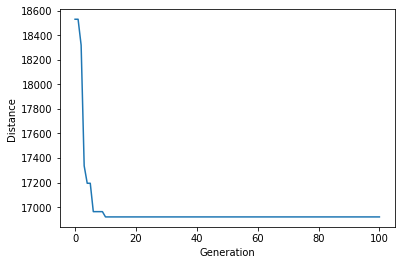

In [20]:
# Run geneticAlgorithmPlot
geneticAlgorithmPlot(airport_cord, popSize=100, eliteSize=20, mutationRate=0.01, generations=100)